# What this simulation hopes to achieve

1. Generate a map from a known power law in the $A_s$. Do this using `synfast`.
    
1. Generate the SED (spectral energy density) using the fact that $m_\nu = A_S \times \textrm{SED}(\nu)$. Use `anafast` to generate a map here.
    
1. Now allow the index to vary spatially, perhaps beginning with letting $\beta_s = -3 \pm \rm random$.
    
1. Generate new "realistic maps" using this spatially varying index: 
$$
m_\nu = A_s \times \textrm{SED}(\beta_s)
$$
    
1. From this, extract a power spectrum and compare it to the known power spectrum from before.

## Maths (for synchrotron)

The relevant equations here are
$$
\textrm{SED} = \left(\frac{\nu}{\nu_0}\right)^{2+\beta_s}
$$
with $\nu_0 \sim 30 \ \rm GHz$. The frequencies are typically in the range 20-300 GHZ. $\beta_s$ is typically about -3. The associated $A_s$s are also given by a power law
$$
C_\ell^s = A_s \times \left(\frac{\ell}{\ell_*}\right)^{\alpha_s}
$$
where typical $\ell$ are 2-500, $\ell_* = 80$ and $\alpha_s \sim -3$

In [132]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [133]:
import healpy as hp

In [134]:
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS

## Section 1: Generating $A_s$ maps

In [135]:
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

In [136]:
#define the synchrotron SED.
"""I'm not 100% sure what is going on here, for example,
and what the [..., np.newaxis] is doing"""
"""Is beta an array so that we can allow it to vary with position?"""
"""Aren't we modelling synchrton as just a power law (and dust with the modified black body)? Why do we have
a black body here?"""

#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 


def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit

In [137]:
#define the BB parameter values (to start)
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

In [138]:
"""set the nside parameter, which determines the 
resolution of the map. This should be a power of 2"""
nside = 128

In [139]:
#define an array of the input ell from 1 to ellmax, this avoids the division by 0 issue
Lmax = 384
ells = np.arange(1,Lmax+1)

In [140]:
"""defining the power law c_ells (the pcls through) C_ell(power) = A_BB * (ell/80)^alpha_BB"""
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 #this sets what will by the C_1 element =0 
pcls[1] = 0

Text(0.5, 1.0, 'Power spectrum - power law')

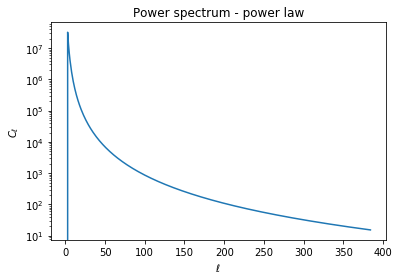

In [141]:
#how the C_ell vary with ell 
semilogy(ells,pcls)
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Power spectrum - power law")

This is the inputted power spectrum.

In [142]:
#produces the output map based on the given C_ell and the resolution desired.
sbb = hp.synfast(pcls, nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


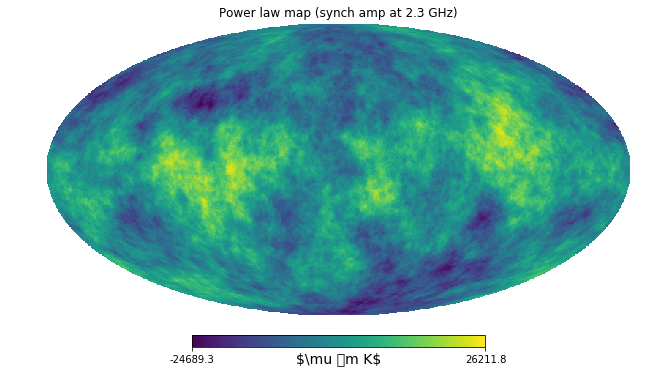

In [143]:
#view the map made above
hp.mollview(sbb, unit='\$\mu \rm K\$', title='Power law map (synch amp at 2.3 GHz)')

In [144]:
#now extract the power spectrum (the C_ells) from the map
check_cls = hp.anafast(sbb)

(1, 100000000.0)

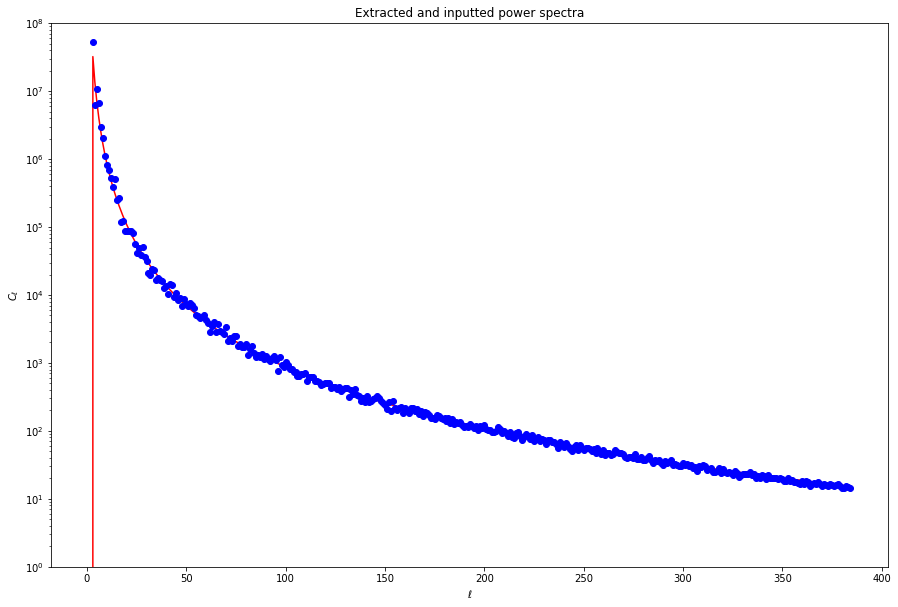

In [145]:
#compare the measured C_ell to the input C_ell curve
figure(figsize=(15,10))
semilogy(ells, pcls, 'r')
semilogy(ells, check_cls, 'bo')
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Extracted and inputted power spectra")

ylim(1, 1e8)

As expected, these match pretty well. We now want to put in the power law of the spectral energy density (SED).

## Section 2: Produce the full map including the SED

Recall that the full map is defined as 
$$
m_\nu = A_s \cdot \textrm{SED}(\nu)
$$
Now, as the $A_s$ is a power law we can write this as
$$
m_\nu = \left(\frac{\ell}{\ell_*}\right)^{\alpha_s} \times \left(\frac{\nu}{\nu_0}\right)^{\beta_s}
$$

Text(0.5, 1.0, 'Power law dependency of SED on frequency')

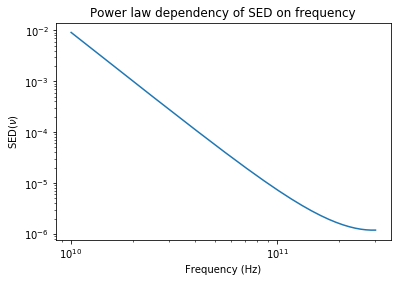

In [146]:
#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9


#define the SED scaling
sed_scaling = scale_synch(freqs, beta_BB)


#plot the SED against frequency (on log log plot)
loglog(freqs, sed_scaling)
xlabel("Frequency (Hz)")
ylabel(r"$\mathrm{SED}(\nu)$") #the r is needed for the LaTeX
title("Power law dependency of SED on frequency")

In [147]:
newmaps = sbb * sed_scaling[..., np.newaxis]
"""I don't totally get what's happening here. I don't understand
the slicing or what these maps are."""
#the 0th component of the shape is the different freqnencies
#I think these are maps with the power spectra defined above, at different frequencies, but I am confused
print(newmaps.shape)

(20, 196608)


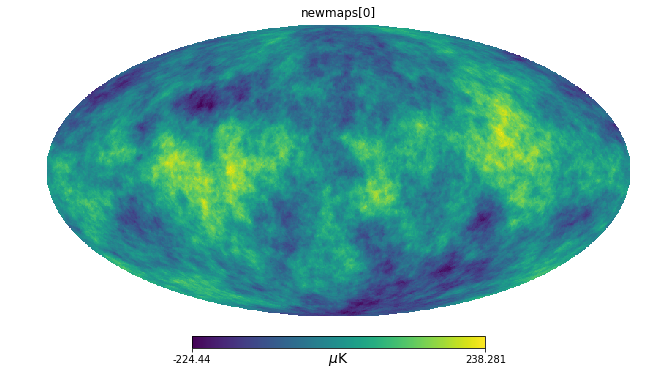

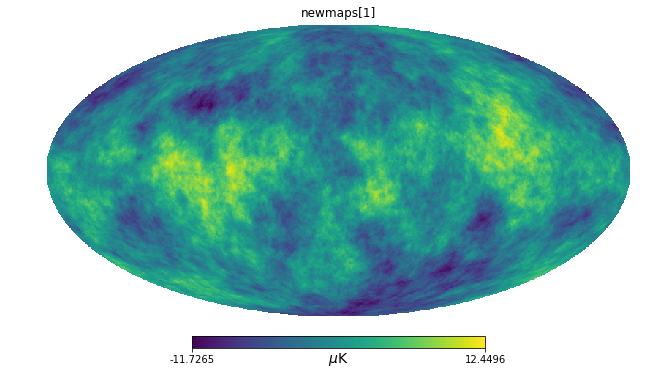

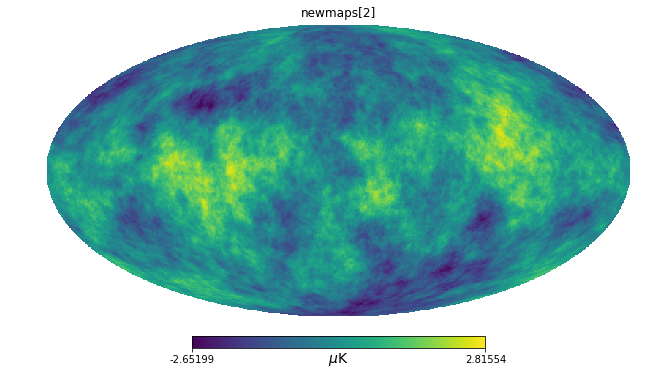

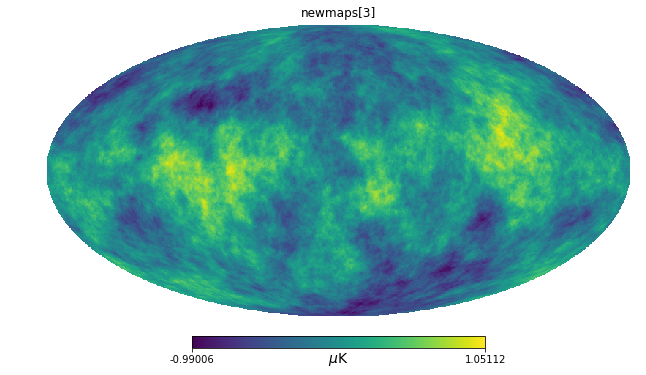

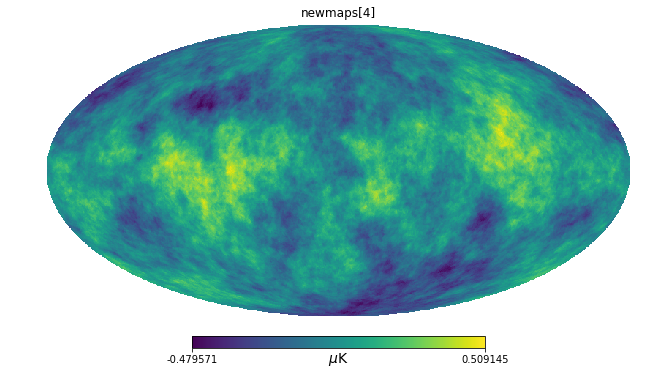

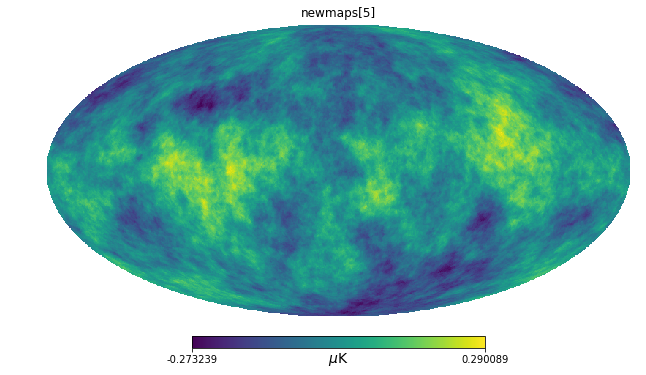

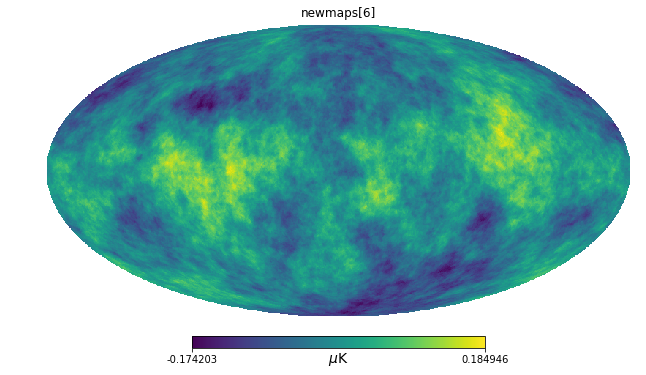

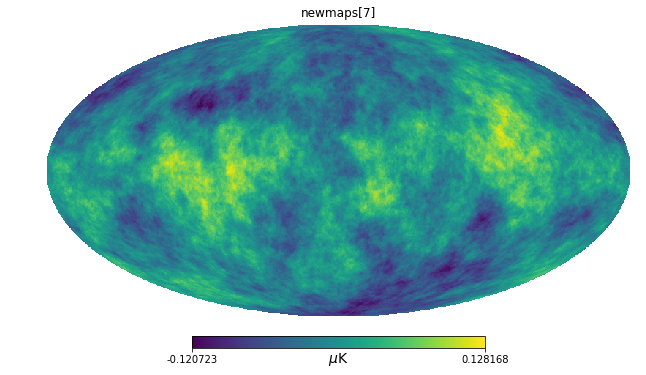

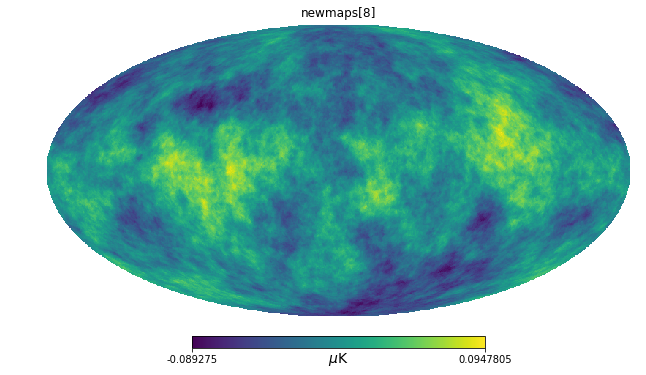

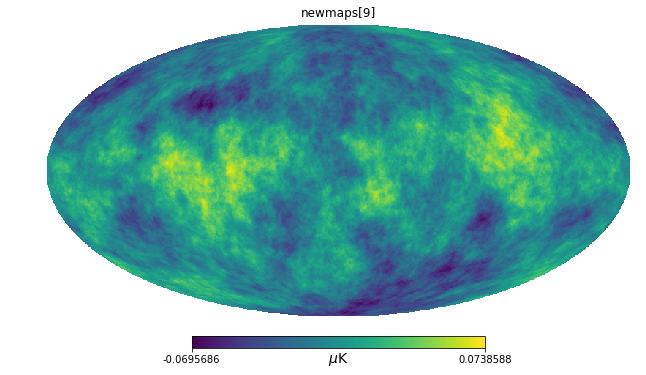

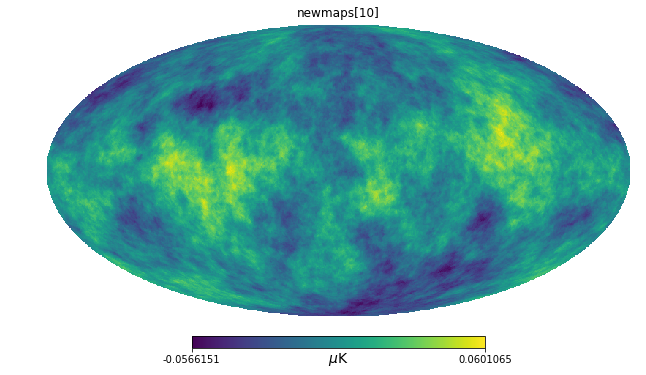

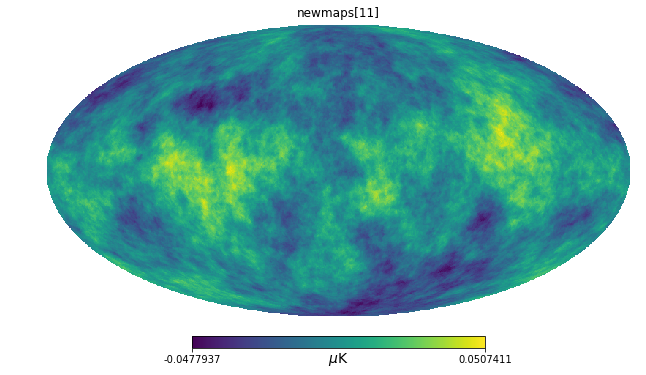

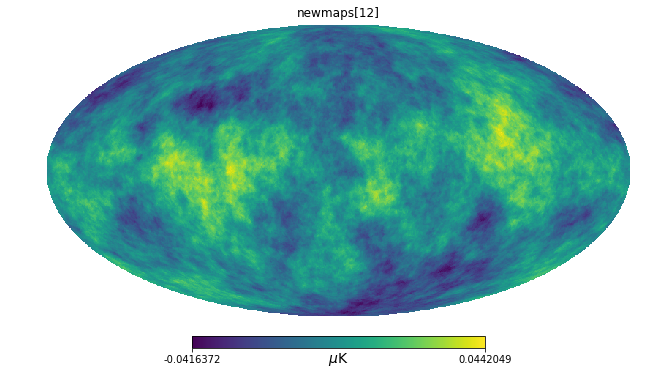

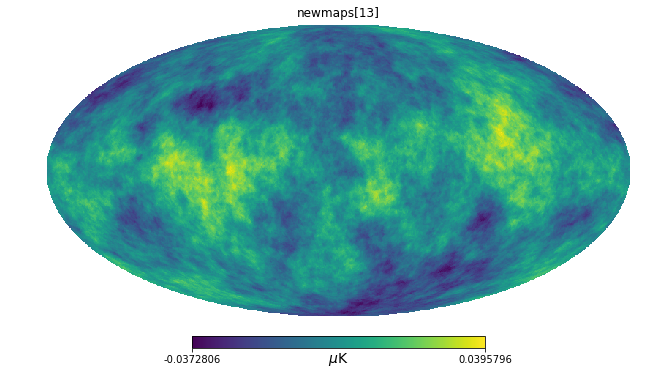

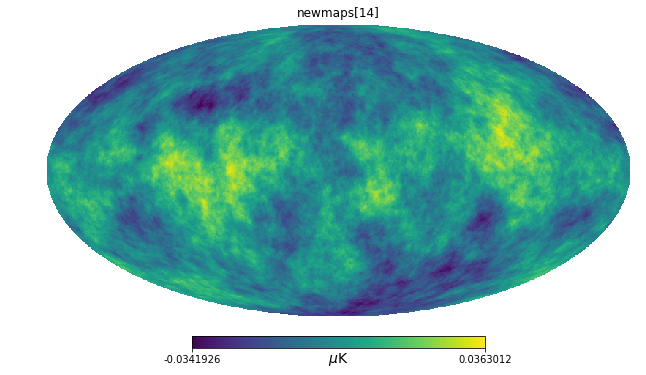

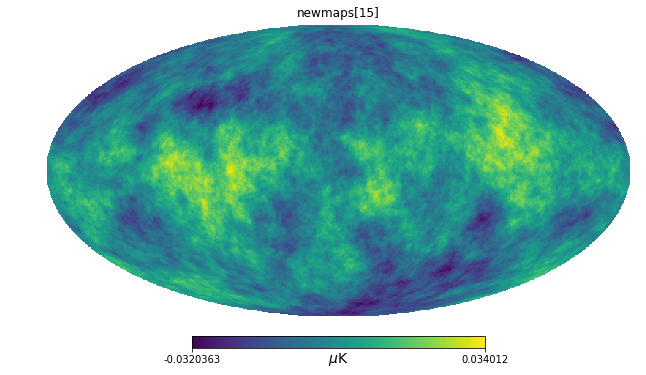

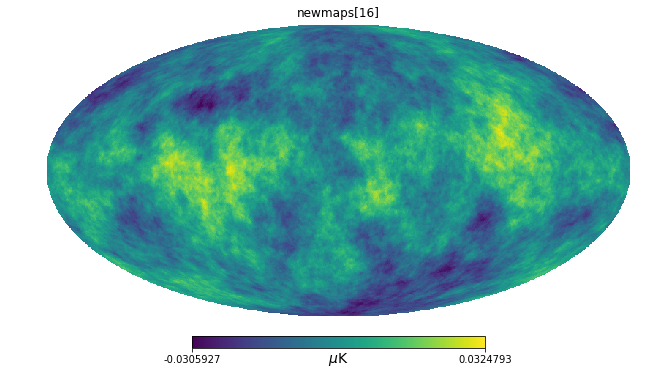

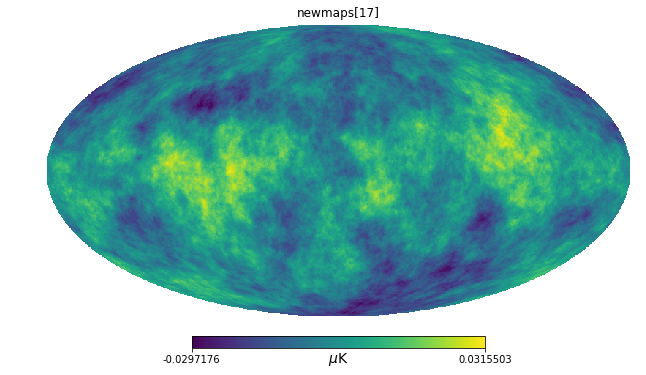

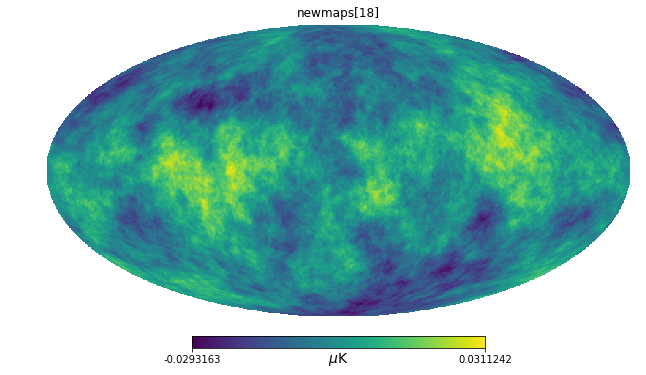

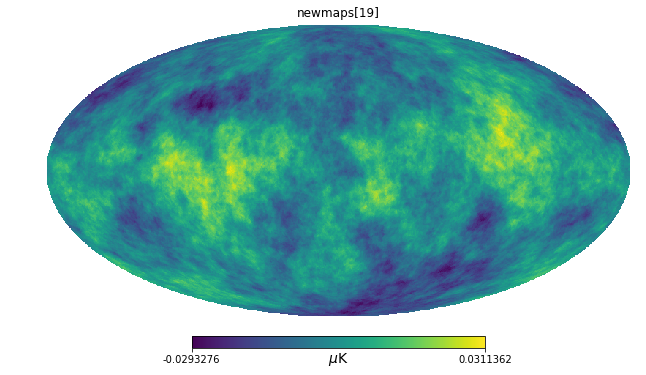

In [148]:
#maps at different frequencies???
for k in range(20):
    hp.mollview(newmaps[k], title = "newmaps[%d]" %k, unit = r"$\mu \rm K$")

# Section 3: Allow $\beta_s$ to vary with space

Begin by defining a $\beta$ vector that varies randomly with space

In [170]:
'''
#doesn't work as the beta are not varying in space

#change beta_BB from a scalar into a vector with the same number of elements as the ells, then add a random 
#number to it

vec_beta_BB = beta_BB * ones_like(ells) 
noise = 0.1*(0.5*ones_like(ells) - rand(Lmax))
noisy_beta_BB = vec_beta_BB + noise

plot(ells, noisy_beta_BB)
xlabel("$\ell$")
ylabel("beta")

beta_map = hp.synfast(noisy_beta_BB, nside)
hp.mollview(beta_map)
'''

'\n#doesn\'t work as the beta are not varying in space\n\n#change beta_BB from a scalar into a vector with the same number of elements as the ells, then add a random \n#number to it\n\nvec_beta_BB = beta_BB * ones_like(ells) \nnoise = 0.1*(0.5*ones_like(ells) - rand(Lmax))\nnoisy_beta_BB = vec_beta_BB + noise\n\nplot(ells, noisy_beta_BB)\nxlabel("$\\ell$")\nylabel("beta")\n\nbeta_map = hp.synfast(noisy_beta_BB, nside)\nhp.mollview(beta_map)\n'

# WHY use $\beta_\sigma$ or $\beta_{BB}$? I don't quite follow the theory of this section

Create a map with some fixed $C_\ell$, then subtract off the mean and add the ''true'' value of $\beta$ to it

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


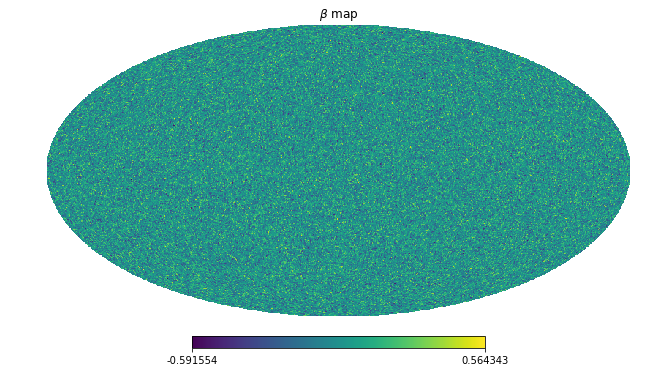

In [171]:
#why this value, how much meaning does this have?
beta_sigma = 1.5e-6

beta_cls = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map = hp.synfast(beta_cls, nside)   #makes a map from these c_ells

hp.mollview(beta_map, title=r"$\beta \ \rm map$")

-3.2000000000000006


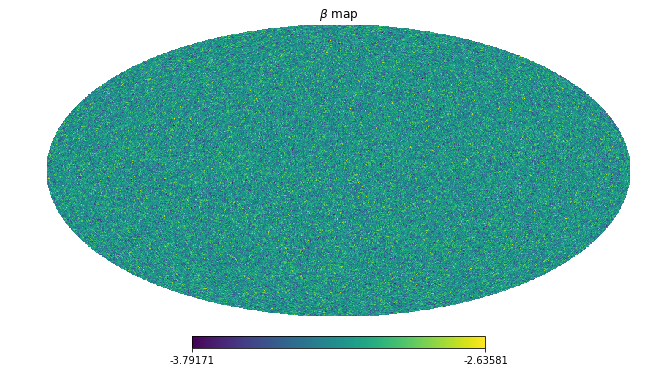

In [172]:
#update the map so that the mean is correct
beta_map -= (np.mean(beta_map) + 3.2)
print(np.mean(beta_map))

hp.mollview(beta_map, title=r"$\beta \ \rm map$")

In [173]:
#want to check the beta_cls against the input, flat spectrum
check_bcls = hp.anafast(beta_map) #extract the c_ell from the beta map
np.sqrt(check_bcls[0]/(4*pi)) #should be near -3.2

3.1999994267033265

Text(0.5, 1.0, 'Uniform $\\beta$ across sky')

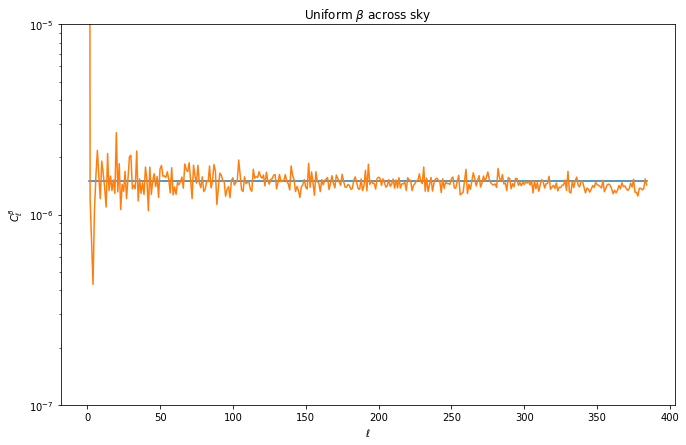

In [174]:
figure(figsize=(11,7))
semilogy(ells, beta_cls)
semilogy(ells, check_bcls)
ylim(1e-7, 1e-5)
xlabel("$\ell$")
ylabel(r"$ C_\ell^{\beta}$") 
title(r"Uniform $\beta$ across sky")

notice that the ''noise'' around the mean decreases as $\ell$ increases. This is cosmic variance and is a consequence of the fact that we only have one map. This is what happens if the $C_\ell$ are constant for all $\ell$ (in this case they are $1.5\times 10^{-6}$). We now want to let the $\beta$ become $\beta(\ell)$ by defining 
$$
\beta = \beta_0 + \mathrm{random} 
$$
where the random is ~0.1 and so, $\ell$ has a different, and uncorrelated value of $\beta$.

-3.2006904672181355


Text(0, 0.5, '$C_\\ell^\\beta$')

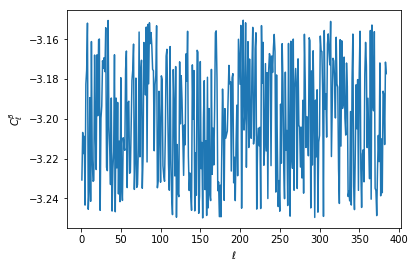

In [175]:
noisy_beta_cls = beta_BB * ones_like(ells)
noise = 0.1*(0.5*ones_like(ells) - rand(Lmax))
noisy_beta_cls += noise

print(np.mean(noisy_beta_cls))


plot(ells, noisy_beta_cls)
xlabel(r"$\ell$")
ylabel(r"$C_\ell^\beta$")


#This is random noise centred around the value of beta_BB. Should this be what I'm doing or should it be centred on 0?

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


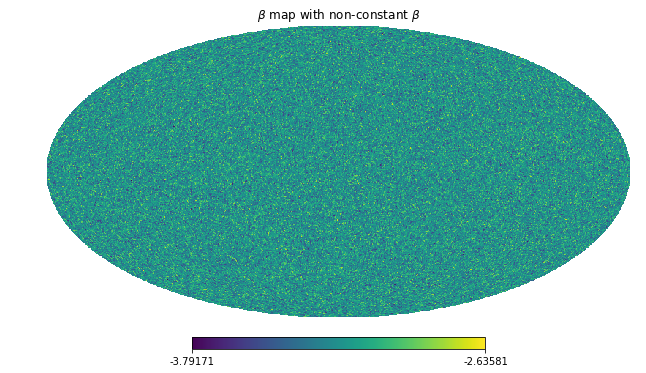

In [176]:
noisy_beta_map = hp.synfast(noisy_beta_cls, nside)
hp.mollview(beta_map, title=r"$\beta \ \rm map$ with non-constant $\beta$")

-3.2000000000000015


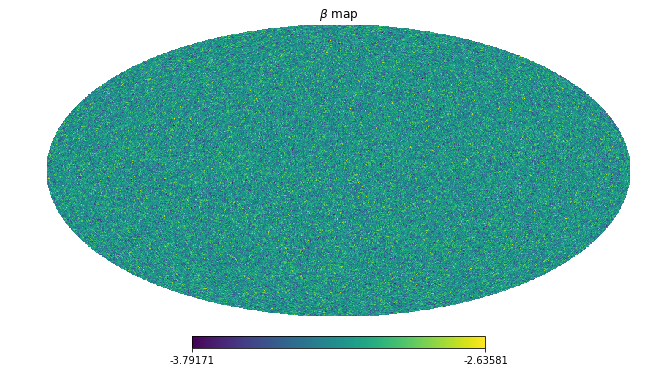

In [177]:
#again, update the map so the mean is correct
noisy_beta_map -= (np.mean(noisy_beta_map) + 3.2)
print(np.mean(noisy_beta_map))

hp.mollview(beta_map, title=r"$\beta \ \rm map$")

In [178]:
#extract the beta_cls from this noisy map
check_noisy_bcls = hp.anafast(noisy_beta_map)
np.sqrt(check_noisy_bcls[0]/(4*pi))

3.1999994069091073

Text(0.5, 1.0, 'Noisy $C_\\ell$ from the variation in $\\beta$')

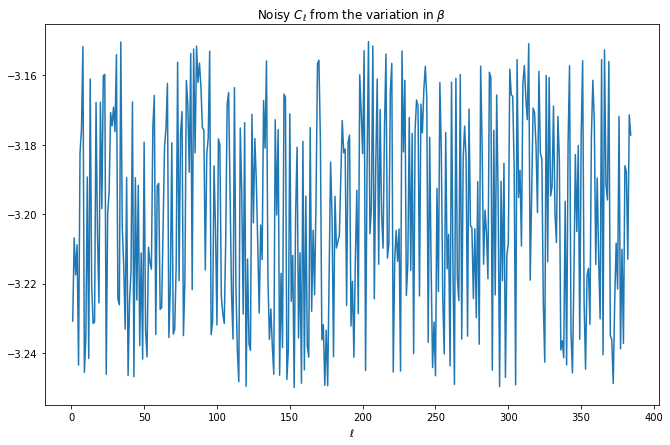

In [179]:
figure(figsize=(11,7))
plot(ells, noisy_beta_cls)
#semilogy(ells, check_noisy_bcls)
#ylim(1e-7, 1e-5)
xlabel("$\ell$")
title(r"Noisy $C_\ell$ from the variation in $\beta$") 

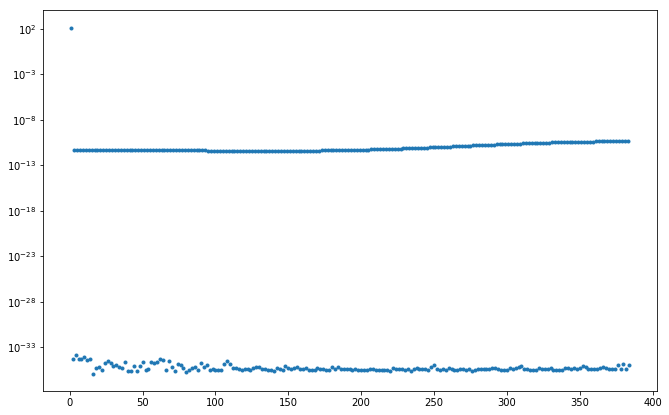

In [180]:
figure(figsize=(11,7))
semilogy(ells, check_noisy_bcls, ".")



# UMMMM...what?

# Different attempt
Try making the $C_\ell^\beta$ be centred on $\beta_\sigma = 1.5\times 10^{-6}$ and have the random fluctuations be of order $10^{-7}$

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


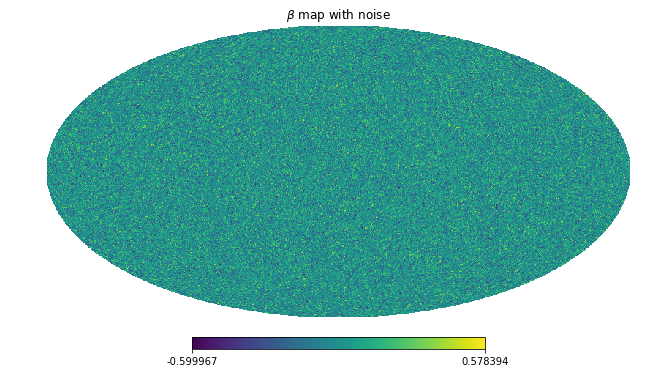

In [203]:
beta_cls_2 = beta_sigma * ones_like(ells)
noise = 3e-7*(0.5*ones_like(ells) - rand(Lmax))
beta_cls_2 += noise

beta_map_2 = hp.synfast(beta_cls_2, nside, new=True)   #makes a map from these c_ells

hp.mollview(beta_map_2, title=r"$\beta \ \rm map \ with \ noise$ ")

update this map so the mean is correct

-3.2000000000000006


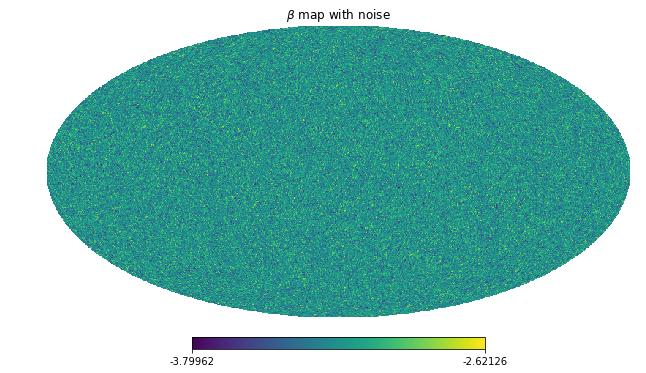

In [204]:
beta_map_2 -= (np.mean(beta_map_2) + 3.2)
print(np.mean(beta_map_2))

hp.mollview(beta_map_2, title=r"$\beta \ \rm map \ with \ noise$")

In [205]:
#want to check the beta_cls against the input, flat spectrum
check_bcls_2 = hp.anafast(beta_map_2) #extract the c_ell from the beta map
np.sqrt(check_bcls_2[0]/(4*pi)) #should be near -3.2

3.1999994204360056

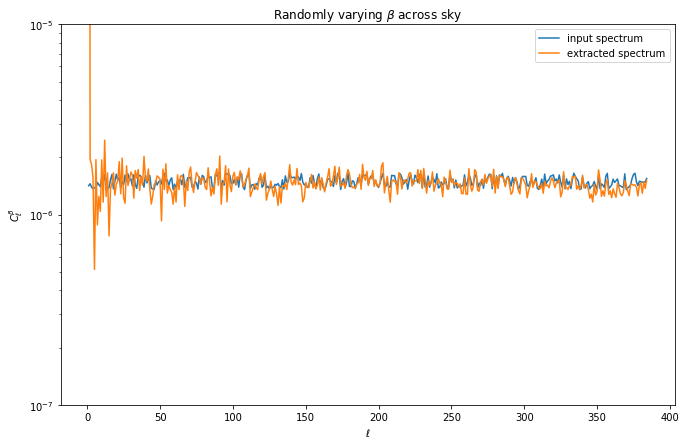

In [206]:
figure(figsize=(11,7))
semilogy(ells, beta_cls_2, label="input spectrum")
semilogy(ells, check_bcls_2, label='extracted spectrum')
ylim(1e-7, 1e-5)
xlabel("$\ell$")
ylabel(r"$ C_\ell^{\beta}$") 
title(r"Randomly varying $\beta$ across sky")
legend()

# Section 4: Generate "realistic" maps

Here we want to generate maps using
$$
m_\nu = A_s \times \textrm{SED}(\nu, \beta_s(\ell))
$$

# Section 5: Extract power spectra from realistic maps